In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# SVMスクラッチ

最終系を⇩にまとめる

In [756]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """
    def __init__(self, num_iter, lr, kernel='linear', gamma=1, theta=0, d=1, threshold=1e-5, verbose=False, debug=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        self.gamma = gamma
        self.theta = theta
        self.d = d
        
        self.n_support_vectors = 0
        self.index_support_vectors = None
        self.X_sv = None
        self.lam_sv = None
        self.y_sv  = None
        
        #デバッグ用データ
        self.debug = debug
        self.my_lambda = np.array([0.3, 0.2, 0.6]).reshape(-1, 1)
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        #検証データの計算を行うかどうか
        is_val_calc = (X_val is not None) and (y_val is not None)
        
        #データを加工・整形
        X, y = self._data_processing(X, y)
        
        if is_val_calc:
            X_val, y_val  = self._data_processing(X_val, y_val)
        
        #サンプル数に合わせて、λの初期値をランダムにセット
        if self.debug:
            self._lambda = self.my_lambda
        else:
            self._lambda = np.random.rand(len(X), 1)
        
        #イテレータ回数分学習を行う
        for _iter in range(num_iter):
            self._lagrange(X, y)
        
            #verboseをTrueにした際は学習過程を出力
            if self.verbose:
                print(self._lambda)
        
        #サポートベクターの決定
        self.index_support_vectors = np.where(self._lambda > self.threshold)[0]
        self.n_support_vectors = len(self.index_support_vectors)

        self.X_sv = X[self.index_support_vectors]
        self.lam_sv = self._lambda[self.index_support_vectors]
        self.y_sv  = y[self.index_support_vectors]
        
        print("number of support_vector is {}".format(self.n_support_vectors))
        
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        
        X, _ = self._data_processing(X)
        
        pred = np.sum(self.lam_sv * self.y_sv * self._kernel(self.X_sv, X), axis=0).reshape(-1, 1)
        pred = np.where(pred >= 0, self.y_true, self.y_false)
        
        return pred
    
    def _kernel(self, Xi, Xj):
        if self.kernel == "linear":
            K = Xi @ Xj.T
            return K
        
        elif self.kernel == "poly":
            K = (self.gamma * (Xi @ Xj.T) + self.theta)**self.d
            return K
        
        else:
            raise ValueError("not exist {}".format(self.kernel))
            
    def _lagrange(self, X, y):
        sigma = np.sum(self._lambda.T * y * y.T * self._kernel(X, X), axis=1).reshape(-1, 1)
        self._lambda += self.lr * (1 - sigma)

        self._lambda = np.where(self._lambda < 0, 0, self._lambda)
        
    def _data_processing(self, X, y=None):
        # データセットがDataFrame, Seriesの場合ndarrayに変換する
        if isinstance(X, (pd.DataFrame, pd.Series)):
            X = X.values
        if isinstance(y, (pd.DataFrame, pd.Series)):
            y = y.values
        
        # データセットが1次元の場合、2次元に変換する
        if X.shape[0] == X.size:
            X = X.reshape(-1, 1)
        
        if y is not None:
            y = y.reshape(-1, 1)
        
            # yの値を1,-1に変換
            self.y_true = y.max()
            self.y_false = y.min()

            y = np.where(y == self.y_true, 1, -1)

        return X, y

## 【問題1】ラグランジュの未定乗数法による最急降下
SVMの学習は、ラグランジュの未定乗数法を用います。サンプル数分のラグランジュ乗数 λを用意して、

以下の式により更新していきます。この計算を行うメソッドをScratchSVMClassifierクラスに実装してください。

$\lambda_i^{new} = \lambda_i + \alpha(1 - \sum_{j=1}^{n}{\lambda_j y_i y_j k(x_i, x_j)})$

ここで$k(x_i, x_j) = x_{i}^{T} x_j$ はカーネル関数です。線形カーネルの場合は次のようになります。

他のカーネル関数にも対応できるように、この部分は独立したメソッドとしておきましょう。

$k(x_i, x_j) = x_{i}^{T} x_j$

あるサンプルに対しての全てのサンプルとの関係を計算していくことになります。

## 【問題2】サポートベクターの決定
計算したラグランジュ乗数 λ が設定した閾値より大きいサンプルをサポートベクターとして扱います。

推定時にサポートベクターが必要になります。サポートベクターを決定し、インスタンス変数として保持しておくコードを書いてください。

閾値はハイパーパラメータですが、1e-5程度からはじめると良いでしょう。

サポートベクターの数を出力させられるようにしておくと学習がうまく行えているかを確認できます。

## 【問題3】推定
推定時には、推定したいデータの特徴量とサポートベクターの特徴量をカーネル関数によって計算します。求めた 
$f(x)$ の符号が分類結果です。


In [757]:
# テストデータを作って予測してみる
num_iter = 100
lr = 0.001

X = np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
y = np.array([-1, -1, 1])

svm = ScratchSVMClassifier(num_iter=num_iter, lr=lr, verbose=True, debug=True)
svm.fit(X, y)


[[0.3204]
 [0.2492]
 [0.524 ]]
[[0.33514  ]
 [0.2846868]
 [0.4697664]]
[[0.34582638]
 [0.31035294]
 [0.43112051]]
[[0.35360954]
 [0.32898602]
 [0.40363751]]
[[0.35931333]
 [0.34258237]
 [0.3841486 ]]
[[0.36352774]
 [0.35257163]
 [0.37038449]]
[[0.36667529]
 [0.35997763]
 [0.36072002]]
[[0.36905855]
 [0.36553359]
 [0.35399137]]
[[0.37089422]
 [0.36976458]
 [0.34936507]]
[[0.37233749]
 [0.37304663]
 [0.34624424]]
[[0.37349949]
 [0.37564903]
 [0.34420142]]
[[0.37445979]
 [0.37776465]
 [0.3429305 ]]
[[0.37527541]
 [0.37953158]
 [0.34221226]]
[[0.37598716]
 [0.38104873]
 [0.3418897 ]]
[[0.37662427]
 [0.38238693]
 [0.3418504 ]]
[[0.37720766]
 [0.38359691]
 [0.34201384]]
[[0.37775235]
 [0.38471499]
 [0.34232237]]
[[0.37826905]
 [0.38576719]
 [0.34273467]]
[[0.37876547]
 [0.38677214]
 [0.3432212 ]]
[[0.37924711]
 [0.38774317]
 [0.34376076]]
[[0.3797179 ]
 [0.38868985]
 [0.34433819]]
[[0.38018069]
 [0.38961902]
 [0.34494264]]
[[0.38063748]
 [0.39053558]
 [0.34556632]]
[[0.38108973]
 [0.39144303

In [758]:
X_test = np.array([[1, 2, 3],[4, 5, 6],[7, 8, 9]])
svm.predict(X_test)

array([[-1],
       [-1],
       [ 1]])

## 【問題4】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット1の2値分類に対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。

AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。

In [759]:
import numpy as np
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]
f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))
X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)
random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

In [760]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score

#ハイパーパラメータ
num_iter = 500
lr = 0.001
threshold = 1e-5

#モデル作成
sklearn_svc = SVC(kernel="linear")
scracth_svc = ScratchSVMClassifier(num_iter=num_iter, threshold=threshold, lr=lr, kernel="linear")

model_dict = {"sklearn": sklearn_svc, "scratch": scracth_svc}

#テストデータ分割
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

results = pd.DataFrame(index=range(len(model_dict)) ,columns=["model_name", "accuracy"])
i = 0

for name, model in model_dict.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.loc[i, :] = [name, accuracy]
    i += 1
    
results

number of support_vector is 10


,model_name,accuracy
0,sklearn,1
1,scratch,1


sklearnと同じ結果になった

## 【問題5】決定領域の可視化
決定領域を可視化してください。

サポートベクターは異なる色で示してください。

In [761]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    
    plt.scatter(model.X_sv[:, 0], model.X_sv[:, 1], s=80, c="yellow", marker="o")
    
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

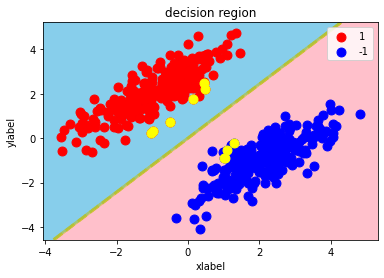

In [762]:
decision_region(X, y, scracth_svc, target_names=[1, -1])

## 【問題6】（アドバンス課題）多項式カーネル関数の作成

最初に作成した実装では線形カーネルを使用していました。多項式カーネルにも切り替えられるようにしましょう。

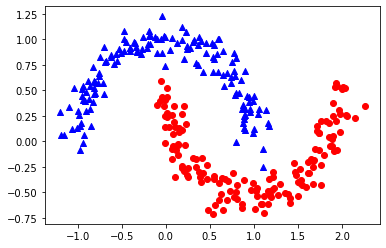

In [763]:
from sklearn.datasets import make_moons

moons = make_moons(n_samples=300, noise=0.1, random_state=0)
X = moons[0]
y = moons[1].reshape(-1, 1)
data = np.concatenate([X, y], axis=1)
plt.scatter(data[data[:, 2] == 0][:,0], data[data[:, 2] == 0][:,1], marker="^", color="b")
plt.scatter(data[data[:, 2] == 1][:,0], data[data[:, 2] == 1][:,1], marker="o", color="r")

上のような境界線が曲線のデータセットを用いて多項式カーネルで学習を行ってみる

In [764]:
#ハイパーパラメータ
num_iter = 2000
lr = 1e-4

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc_poly = ScratchSVMClassifier(num_iter=num_iter, lr=lr ,kernel='poly', d=3, gamma=0.5, theta=1)

svc_poly.fit(X_train, y_train)

number of support_vector is 133


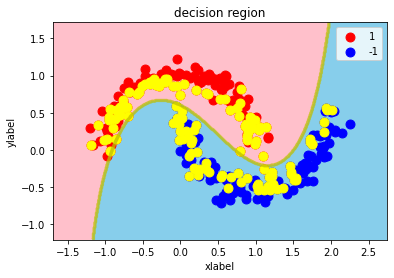

In [765]:

decision_region(X, y.flatten(), svc_poly, target_names=[1, -1])

mlxtendモジュールを用いて境界線を描いてみる

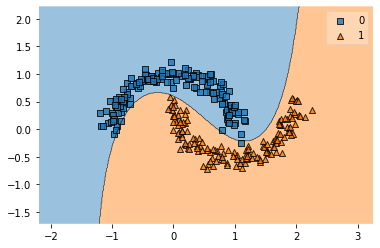

In [766]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, y.flatten(), svc_poly)